# Grasping an object

For this laboratory, we will use two robots distant from each other of 30cm as depicted in the figure below

<img src="./2_robot_config.png" width="500">

There is 1cm between the end-effector "shell" and the position of the frame as depicted in the figure below
<img src="./foot_close.png" width="300">

The object to grasp is a 15cm wide, 10cm high box that weighs 500g.
<img src="./box.png" width="300">

The goal of the notebook is to find a controller and a sequence of movements that enable to grasp an object, lift it up 15cm and then put it on the ground 10cm closer to robot 2. 



In [1]:
#setup nice plotting (use widget instead of notebook in the command below if you use jupyter lab)
%matplotlib notebook

# we import useful libraries
import time
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

use_real_robot_computer = False
use_real_robot = False

if use_real_robot_computer:
    from nyu_finger import NYUFingerReal
    from nyu_finger_sim.nyu_finger_simulator import NYUFingerSimulator
else:
    from nyu_finger_simulator import NYUFingerSimulator


import robot_kinematics

In [2]:
# we create a robot simulation
if use_real_robot:
    robot1 = NYUFingerReal()
    robot1.initialize('enp5s0f1')
    
    robot2 = NYUFingerReal()
    robot2.initialize('eno1')

else:
    robot1 = NYUFingerSimulator(robotStartPos = [0.,0.,0.])
    robot1.add_box(friction=0.5)
    # we put the 2nd robot 0.3m away
    robot2 = NYUFingerSimulator(robotStartPos = [0.3,0.,0.])
    # we reset the simulation to the initial position we want to move
    robot1.reset_state(np.array([0.0,0.0,0.3]))
    robot2.reset_state(np.array([0.0,0.0,-0.3]))
    robot1.step()
    robot1.step()

The code below implements a sequence of movements towards a list of setpoints (defined in `set_points_rob1` and `set_points_rob2` for each robot). These setpoints for now move the end-effectors towards the object and then move the end-effectors up and down.

The controller is an impedance controller (with stiffness K and damping D - set to fixed values for both robots). Additionally, gravity compensation for the mass of the robot is added to the joint torques.
$$\tau = J_O^T \Big( K (p_{desired} - p_{measured}) + D (\dot{p}_{desired} - \dot{p}_{measured} ) \Big) - g(\theta)$$

## Questions
1. The object weighs 0.5kg, the friction coefficient is $\mu=0.5$ and the stiffness K of the impedance controllers is fixed to $K=150$ in every direction. Additionally, there is 1cm between the finger coordinate frame and the shell of the finger. What distance "inside" the object should the endeffector setpoint be defined for each robot such that it will squeeze the object sufficiently to be able to lift it? (i.e. such that friction can exactly compensate for the mass of the object) Explain your answer.

2. Given your computations, modify the sequence of setpoints such that the robots can lift the object (give a 3mm margin when setting the setpoints inside the object to account for tracking errors and the assumption that the object is static). Plot the motion of the end-effector (desired vs. measured) as a function of time.

3. What happens if you squeeze 1cm more or 1cm less than computed? Is it expected? (plot the results)

4. We would like to additionally compensate for the effect on the robot of the weight of the object when it is lifted. Write a controller that compensates for the weight of the object on both robots when they attempt to lift it (carefull, each robot need to only compensate for half the mass of the robot). Compare its performance with the results of point 2. (remark: the number `current_set_point` can tell you which set_point goal is currently being used in order to know when to start compensating for the object weight).

5. Change the controller and/or sequence of set points in order to put the object down 10cm closer to robot 2. Plot the resulting motions of the end-effectors.

6. (optional) Try any/all of these controllers on the real robots. Save and plot the results.

In [3]:
# some parameters for the trajectory generation
traj_time = 0.0 # the timing for each trajectory
current_set_point = 1 #the current goal position
trajectory_duration = 2. #each trajectory is 2 seconds long

# the list of setpoints for the first robot end-effector
set_points_rob1 = [
    np.array([0.3,-0.25,0.014]), # the first one does not count
    np.array([0.3,-0.25,0.014]),
    np.array([0.3+0.065,-0.25,0.014]),
    np.array([0.3+0.065,-0.1,0.014]),
    np.array([0.3+0.065,-0.25,0.014]),
    np.array([0.3,-0.25,0.014]),
]

# the list of setpoints for the second robot end-effector
set_points_rob2 = [
    np.array([0.3,-0.25,0.014]), # the first one does not count
    np.array([0.3,-0.25,0.014]),
    np.array([0.3-0.065,-0.25,0.014]),
    np.array([0.3-0.065,-0.1,0.014]),
    np.array([0.3-0.065,-0.25,0.014]),
    np.array([0.3,-0.25,0.014]),
]


# we simulate until we go through all the setpoints
run_time = (len(set_points_rob1)-1)*trajectory_duration
dt = 0.001
num_steps = int(run_time/dt)

# we create one kinematic object per robot
kin_robot1 = robot_kinematics.robot_kinematics()
kin_robot2 = robot_kinematics.robot_kinematics()

# we create arrays to store information
simulation_time = np.zeros([num_steps]) # will store the running time

# data from the first robot
measured_joint_positions_robot1 = np.zeros([num_steps,3]) # will store the measured position
measured_joint_velocities_robot1 = np.zeros_like(measured_joint_positions_robot1) # will store the measure velocities
desired_torques_robot1 = np.zeros_like(measured_joint_positions_robot1) # will store the commands we send to the robot
foot_measured_position_robot1 = np.zeros([num_steps,3])
foot_measured_velocity_robot1 = np.zeros([num_steps,3])
foot_desired_position_robot1 = np.zeros([num_steps,3])
foot_desired_velocity_robot1 = np.zeros([num_steps,3])

# data from the second robot
measured_joint_positions_robot2 = np.zeros([num_steps,3]) # will store the measured position
measured_joint_velocities_robot2 = np.zeros_like(measured_joint_positions_robot2) # will store the measure velocities
desired_torques_robot2 = np.zeros_like(measured_joint_positions_robot2) # will store the commands we send to the robot
foot_measured_position_robot2 = np.zeros([num_steps,3])
foot_measured_velocity_robot2 = np.zeros([num_steps,3])
foot_desired_position_robot2 = np.zeros([num_steps,3])
foot_desired_velocity_robot2 = np.zeros([num_steps,3])


# now we can enter the main control loop (each loop is 1 control cycle)
for i in range(num_steps):

    # get the current time and store it
    simulation_time[i] = dt * i
    
    ####SENSOR PROCESSING###
    # we get the position and velocities of the joints for robot1
    q_rob1, dq_rob1 = robot1.get_state()
    measured_joint_positions_robot1[i,:] = q_rob1
    measured_joint_velocities_robot1[i,:] = dq_rob1
    
    # we get the position and velocities of the joints for robot2
    q_rob2, dq_rob2 = robot2.get_state()
    measured_joint_positions_robot2[i,:] = q_rob2
    measured_joint_velocities_robot2[i,:] = dq_rob2
    ########################
    
    
    
    #### KINEMATICS FUNCTIONS ####    
    # compute FK, get Jacobian and compute end-effector velocity for robot1
    kin_robot1.update_kinematics(q_rob1)
    foot_measured_position_robot1[i,:] = kin_robot1.TS_F[0:3,3]
    jacobian_rob1 = kin_robot1.orientedJ[3:6,:]    
    foot_measured_velocity_robot1[i,:] = jacobian_rob1.dot(dq_rob1)
    
    # compute FK, get Jacobian and compute end-effector velocity for robot2
    kin_robot2.update_kinematics(q_rob2)
    foot_measured_position_robot2[i,:] = kin_robot2.TS_F[0:3,3]
    jacobian_rob2 = kin_robot2.orientedJ[3:6,:]    
    foot_measured_velocity_robot2[i,:] = jacobian_rob2.dot(dq_rob2)
    
    ########################
    
    
    
    
    # get the gravity term for each robot (will be used for gravity compensation)
    g_rob1 = kin_robot1.getG()
    g_rob2 = kin_robot2.getG()
    
    
    
    ### TRAJECTORY GENERATION ###
    # here we compute the desired position and velocity of both end-effectors to go from setpoints to setpoints
    # we use the trajectory generator designed in Lab 3
    # the function is stored in the package robot_kinematics.py
    for f in range(3):
        foot_desired_position_robot1[i,f], foot_desired_velocity_robot1[i,f] = robot_kinematics.compute_trajectory(set_points_rob1[current_set_point-1][f], set_points_rob1[current_set_point][f], trajectory_duration, traj_time)
        foot_desired_position_robot2[i,f], foot_desired_velocity_robot2[i,f] = robot_kinematics.compute_trajectory(set_points_rob2[current_set_point-1][f], set_points_rob2[current_set_point][f], trajectory_duration, traj_time)
    
    # here we detect if we need to switch to the next setpoint
    # or if we can just increment the trajectory timing
    if traj_time < trajectory_duration:
        traj_time += dt
    elif current_set_point < len(set_points_rob1)-1:
        traj_time = 0.
        current_set_point += 1
    
    ########################
    
    
    ### CONTROLLER ###
    
    # we use the same K and D gains for both robots
    K = np.diag([150,150,150])
    D = np.diag([5,5,5])
    
    # compute the desired end-effector force for robot 1
    des_force_rob1 = K.dot(foot_desired_position_robot1[i,:] - foot_measured_position_robot1[i,:]) 
    des_force_rob1 += D.dot(foot_desired_velocity_robot1[i,:] - foot_measured_velocity_robot1[i,:])
    
    # impedance controller with gravity compensation for the joints
    desired_torques_robot1[i,:] = (jacobian_rob1.T).dot(des_force_rob1) - g_rob1
    
    # we send the torques to robot 1
    robot1.send_joint_torque(desired_torques_robot1[i,:])
    
    
    # compute the desired end-effector force for robot 2
    des_force_rob2 = K.dot(foot_desired_position_robot2[i,:] - foot_measured_position_robot2[i,:]) 
    des_force_rob2 += D.dot(foot_desired_velocity_robot2[i,:] - foot_measured_velocity_robot2[i,:])
    
    # impedance controller with gravity compensation for the joints
    desired_torques_robot2[i,:] = (jacobian_rob2.T).dot(des_force_rob2) - g_rob2
    
    # we send the torques to robot 2
    robot2.send_joint_torque(desired_torques_robot2[i,:])
    
    ########################
    
    # we call step to do one simulation step (only needs to be called once from one robot)
    robot1.step()

<IPython.core.display.Javascript object>


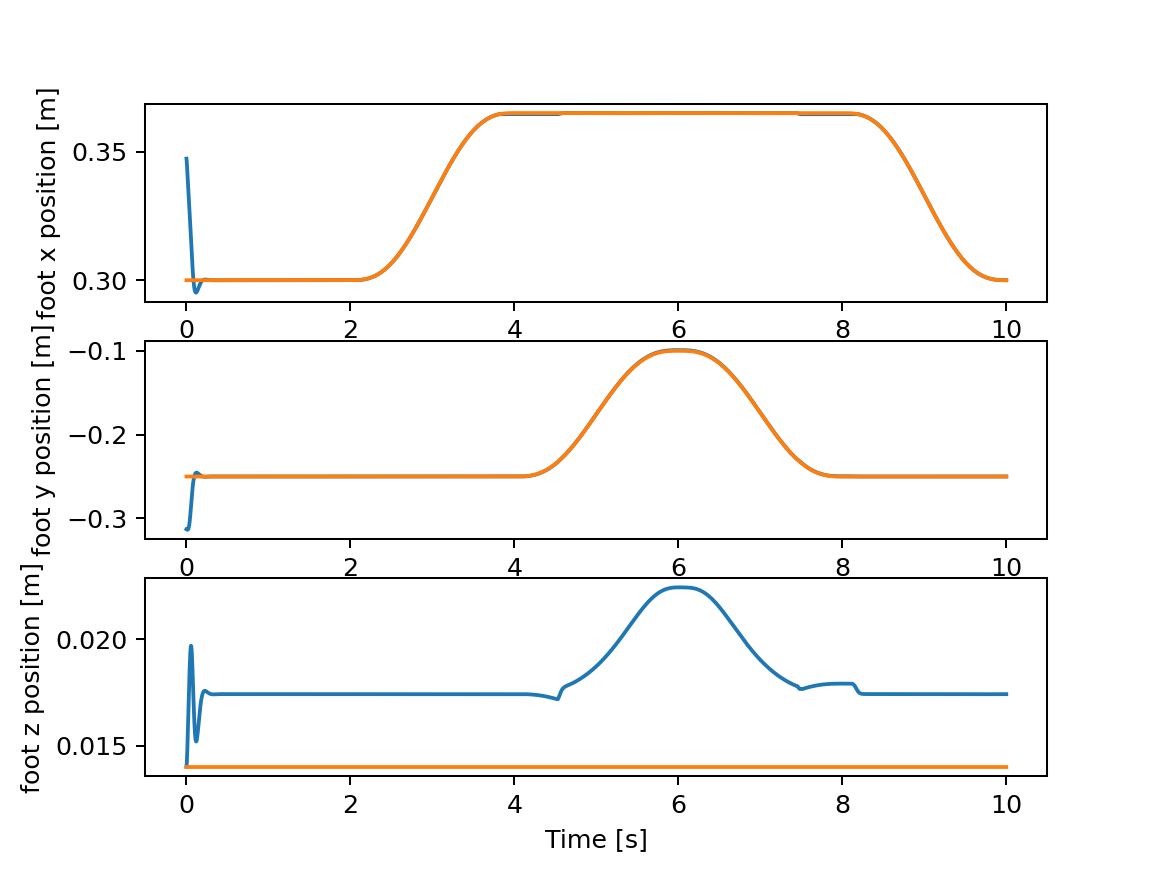

<IPython.core.display.Javascript object>


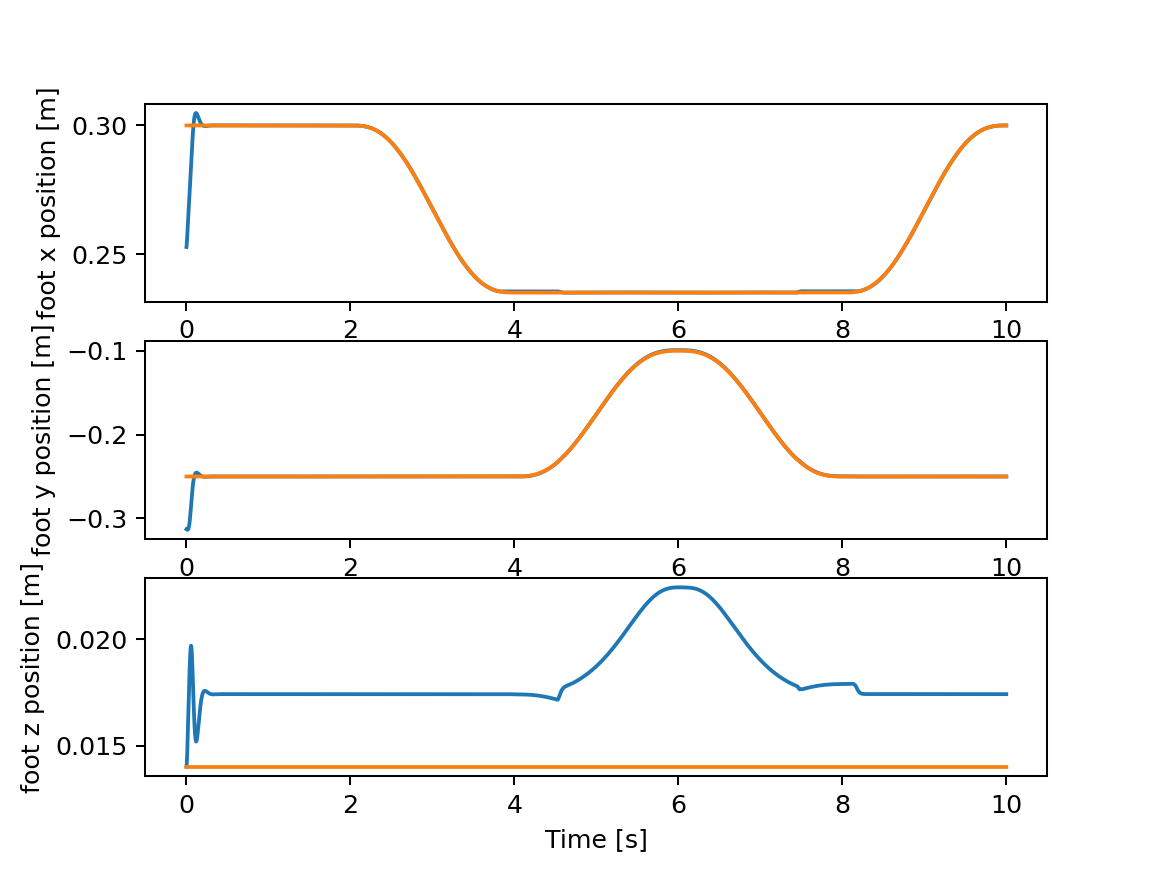

In [4]:
def plot_foot_trajectory(time, foot_pos, foot_pos_des):
    """
    plot the time evolution of the end-effector in 3D vs. the desired trajectories
    """    
    x_pos = foot_pos[:,0]
    y_pos = foot_pos[:,1]
    z_pos = foot_pos[:,2]
    
    plt.figure()
    plt.subplot(3,1,1)
    plt.plot(time, x_pos, time, foot_pos_des[:,0])
    plt.ylabel('foot x position [m]')
    plt.subplot(3,1,2)
    plt.plot(time, y_pos, time, foot_pos_des[:,1])
    plt.ylabel('foot y position [m]')
    plt.subplot(3,1,3)
    plt.plot(time, z_pos, time, foot_pos_des[:,2])
    plt.ylabel('foot z position [m]')
    plt.xlabel('Time [s]')


plot_foot_trajectory(simulation_time, foot_measured_position_robot1, foot_desired_position_robot1)
plot_foot_trajectory(simulation_time, foot_measured_position_robot2, foot_desired_position_robot2)